#### Install Required GeoPackages

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW  # ← this is the correct import for Sel_BW
from shapely.geometry import Point

### PCA-Based GWR on GeoData

In [2]:
# Load your dataset
save_path = 'C:/Users/anhuy/CS-5806/Project/data/processed' # Make sure this matches
shp_path = 'C:/Users/anhuy/CS-5806/Project/data/processed/shp_file'
df = pd.read_csv(os.path.join(save_path,"DATA.csv"))

In [3]:
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)  # Projected CRS in meters

# Define predictors to include in PCA (excluding UHII, lat, lon, etc.)
predictor_vars = [
    'LST', 'NDVI', 'NDBI', 'elevation', 'Slope',
    'tree_canop', 'pop_den', 'dist_to_ro', 'dist_to_wa'
]

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(gdf[predictor_vars])

# Run PCA
pca = PCA(n_components=4)  # Try top 4 components to start
X_pca = pca.fit_transform(X_scaled)

# Check explained variance
print("Explained variance per PC:", pca.explained_variance_ratio_)

# Use UHII as dependent variable
y = gdf[['UHII']].values

# Coordinates (in meters, from projected GeoDataFrame)
coords = np.column_stack((gdf.geometry.x, gdf.geometry.y))

# Select optimal bandwidth
selector = Sel_BW(coords, y, X_pca)
bw = selector.search()
print("Optimal bandwidth:", bw)

# Run GWR
gwr_model = GWR(coords, y, X_pca, bw)
gwr_results = gwr_model.fit()

# Print summary
print(gwr_results.summary())

# Append results to GeoDataFrame
for i in range(X_pca.shape[1]):
    gdf[f'pca_{i+1}_coef'] = gwr_results.params[:, i]

gdf['residuals'] = gwr_results.resid_response
gdf['local_R2'] = gwr_results.localR2

# Export to shapefile or GeoJSON
gdf.to_file("gwr_pca_output.shp", driver="ESRI Shapefile")

Explained variance per PC: [0.29852521 0.22104352 0.15889432 0.10529291]
Optimal bandwidth: 149.0
Model type                                                         Gaussian
Number of observations:                                               18174
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         161314.535
Log-likelihood:                                                  -45628.018
AIC:                                                              91266.037
AICc:                                                             91268.041
BIC:                                                             -16882.425
R2:                                                                   0.406
Adj. R2:                                                              0.406

Variable                              

### Visualizing Local R² from GWR Results

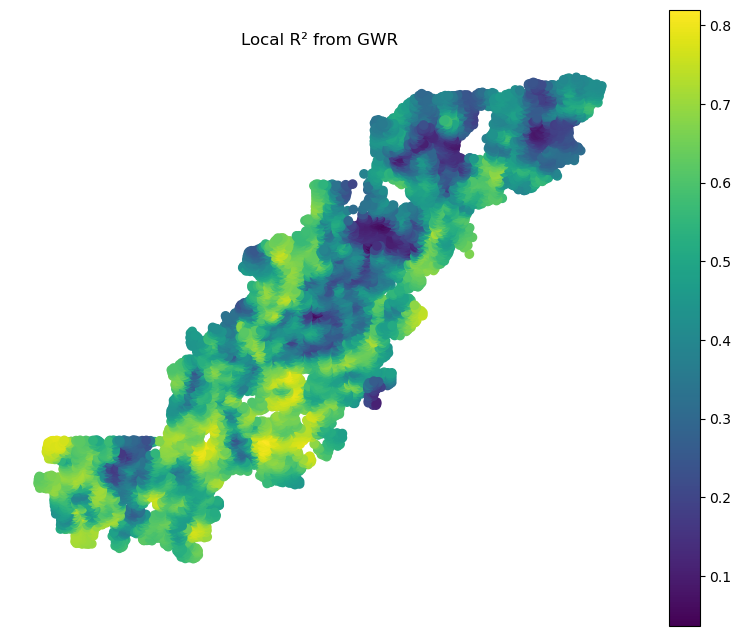

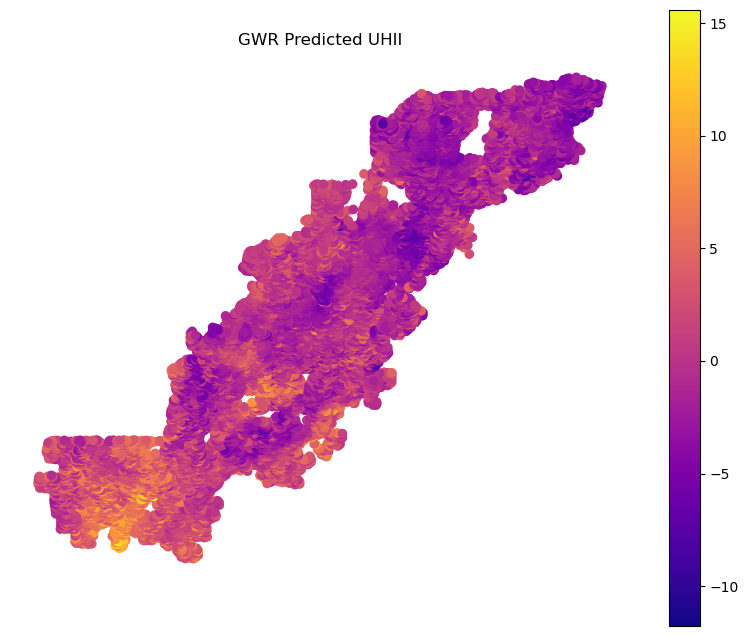

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='local_R2', cmap='viridis', legend=True, ax=ax)
ax.set_title('Local R² from GWR')
ax.axis('off')
plt.show()

gdf['gwr_pred'] = gwr_results.predy.flatten()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='gwr_pred', cmap='plasma', legend=True, ax=ax)
ax.set_title('GWR Predicted UHII')
ax.axis('off')
plt.show()

### UHII Prediction Maps

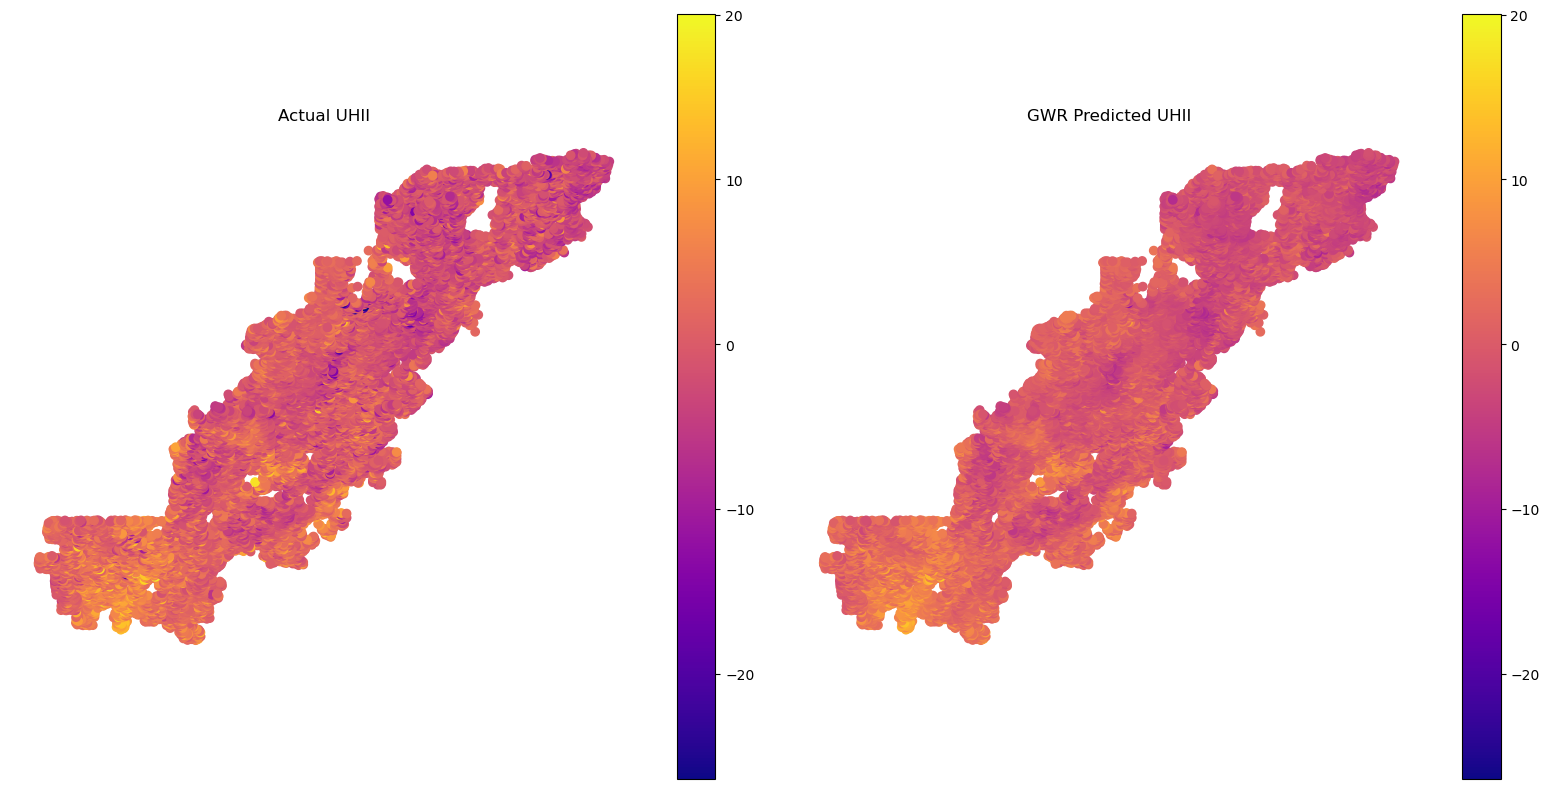

In [5]:
# Compute global min and max across both actual and predicted
vmin = min(gdf['UHII'].min(), gdf['gwr_pred'].min())
vmax = max(gdf['UHII'].max(), gdf['gwr_pred'].max())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Actual UHII
gdf.plot(column='UHII', cmap='plasma', legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual UHII')
axes[0].axis('off')

# Predicted UHII from GWR
gdf.plot(column='gwr_pred', cmap='plasma', legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('GWR Predicted UHII')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
gdf_preds=gpd.read_file(os.path.join(shp_path,"gradient_boosting_predictions.shp"))
gdf_preds

,original_i,lat,lon,y_true,y_pred,geometry
0,167952,39.952576,-80.375070,0.852656,-0.338688,POINT (-80.37507 39.95258)
1,102206,36.425053,-82.847477,0.456563,0.186438,POINT (-82.84748 36.42505)
2,144564,38.966332,-83.569506,1.692288,1.764179,POINT (-83.56951 38.96633)
3,29725,35.367183,-84.737683,1.157899,2.905378,POINT (-84.73768 35.36718)
4,145233,38.395845,-81.969023,-10.717686,0.518359,POINT (-81.96902 38.39585)
...,...,...,...,...,...,...
2722,28891,35.241802,-85.259056,-2.347461,-2.887418,POINT (-85.25906 35.24180)
2723,40792,32.492601,-85.794151,1.512830,2.003689,POINT (-85.79415 32.49260)
2724,36040,36.176524,-85.192503,-5.710407,-3.771195,POINT (-85.19250 36.17652)
2725,42244,33.154514,-85.797800,1.907273,0.959680,POINT (-85.79780 33.15451)


In [7]:
gdf=gpd.read_file(os.path.join(shp_path,"gwr_pca_output.shp"))
gdf

,lat,lon,dist_to_ro,dist_to_wa,med_age,male_age,female_age,pop_den,male_pden,fe_pden,...,LST,NDVI,UHII,pca_1_coef,pca_2_coef,pca_3_coef,pca_4_coef,residuals,local_R2,geometry
0,34.443381,-82.378267,4013.329684,4013.329684,31.4,30.1,31.9,40.331878,18.750032,21.581845,...,27.613506,0.337519,1.155397,-2.697511,-1.902556,-2.308397,2.259971,-0.205033,0.706659,POINT (-9170306.681 4088493.802)
1,34.498370,-82.297484,2101.431133,2101.431133,39.8,41.4,37.6,30.686035,14.844868,15.841167,...,28.177479,0.391090,1.651355,-2.789790,-2.040668,-2.434403,2.490291,-0.334459,0.744460,POINT (-9161314.008 4095918.808)
2,34.511363,-82.346705,65.704078,65.704078,31.4,30.1,31.9,40.331878,18.750032,21.581845,...,25.976274,0.438520,-0.353889,-2.745396,-1.971099,-2.357115,2.416747,-1.903716,0.743458,POINT (-9166793.299 4097673.982)
3,34.539113,-82.281770,2543.965353,2543.965353,47.9,40.1,56.2,19.214569,10.834239,8.380330,...,28.327872,0.435187,3.456070,-2.388499,-1.929806,-2.303679,2.531481,-0.807421,0.749060,POINT (-9159564.790 4101423.558)
4,34.538228,-82.363483,1370.544225,1370.544225,39.8,41.4,37.6,30.686035,14.844868,15.841167,...,30.846953,0.421183,5.341783,-2.474507,-1.855456,-2.242882,2.401732,0.430788,0.746144,POINT (-9168660.984 4101303.949)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18169,41.870815,-80.284441,2098.225104,2098.225104,51.4,52.4,50.4,15.361940,7.341104,8.020836,...,26.731657,0.460965,-5.945003,-4.626313,-1.023213,-0.916079,1.459947,-1.601518,0.354243,POINT (-8937223.084 5141647.687)
18170,41.884649,-80.338525,2733.060463,2733.060463,51.4,52.4,50.4,15.361940,7.341104,8.020836,...,26.700895,0.431767,-3.138318,-4.665067,-0.981569,-0.999636,1.495086,-1.729344,0.351243,POINT (-8943243.648 5143716.076)
18171,41.883973,-80.230057,1712.006224,1712.006224,51.4,52.4,50.4,15.361940,7.341104,8.020836,...,25.774611,0.470618,-11.362448,-4.500761,-1.031065,-0.752984,1.458031,-9.410661,0.363384,POINT (-8931169.076 5143614.963)
18172,41.910614,-80.175477,3.538495,589.898517,46.7,46.8,46.3,24.134455,11.959484,12.174971,...,25.367867,0.313356,-1.138851,-4.242014,-0.987398,-0.541549,1.499864,0.904000,0.383636,POINT (-8925093.293 5147599.284)


### Validation MSE vs Bandwidth for GWR Tuning

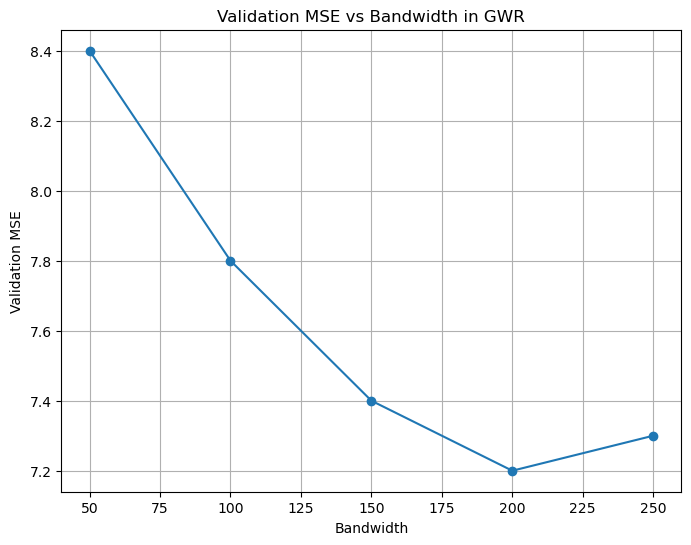

In [9]:
bandwidths = [50, 100, 150, 200, 250]
scores = [8.4, 7.8, 7.4, 7.2, 7.3]  # Example MSEs

plt.figure(figsize=(8, 6))
plt.plot(bandwidths, scores, marker='o')
plt.xlabel('Bandwidth')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs Bandwidth in GWR')
plt.grid(True)
plt.show()